In [1]:
import shapefile
from shapely.geometry import Polygon
from shapely.geometry import Point
import numpy as np
import os 
from couchdb.design import ViewDefinition
import couchdb
from datetime import datetime
import pytz
import pandas as pd
import statsmodels.formula.api as sm

In [2]:
# Load in data
PATH = "./data/mortality/shp/feededc1-8785-49a3-b5fb-da9678c4111b.prj"
PATH2 = "./data/mortality/csv/prematureMortality.csv"
sf = shapefile.Reader(PATH)

shape = sf.shapes()
len(shape)

80

In [3]:
# pmD is the data frame read from csv
pmD = pd.read_csv(PATH2)

In [4]:
pmD = pmD.replace(r'null', np.nan, regex=True)
pmD

,dths_isch_0_74_2_rate_1_08_12_12,dths_tot_0_74_2_rate_1_08_12_12,area_code,area_name,dths_canc_0_74_2_rate_1_08_12_12,dth_dia_0_74_2_rate_1_08_12_12
0,25.324568,217.737633196443,20110,Alpine (S),90.4996873521019,NaN
1,28.676790,310.710373195508,20260,Ararat (RC),127.202416894975,7.15604454724644
2,24.378532,272.713710825711,20570,Ballarat (C),108.898853056264,6.57033901520056
3,16.499854,197.233978676886,20660,Banyule (C),92.9988784808975,3.99257150683635
4,21.849796,228.854805601703,20740,Bass Coast (S),97.7067842142858,5.3573176293173
5,21.535428,239.376485219089,20830,Baw Baw (S),100.356542734089,6.0023005926372
6,11.254516,168.155158684725,20910,Bayside (C),82.9693396047244,3.29110029924942
7,25.606004,280.07212434893,21010,Benalla (RC),129.763444184165,NaN
8,13.286631,150.961177324633,21110,Boroondara (C),75.0199038908681,2.40375121688537
9,25.620079,235.887105874331,21180,Brimbank (C),95.2568807507438,10.4225161019683


In [5]:
# extract from data frame into series
dths_ishchemic = pmD.iloc[:,0]
dths_total = pmD.iloc[:,1]
area_code = pmD.iloc[:,2]
area_name = pmD.iloc[:,3]
dths_cancer = pmD.iloc[:,4]
dths_diabete = pmD.iloc[:,5]

In [6]:
# create for dictionary creation, as there are 80 observations (79 LGAs and one unincorporated area)
zero = [0]*80

In [7]:
# for the record of coordinates, it's a list of one row data, essentially)# 
record = sf.shapeRecords()

In [8]:
record[0].shape.points
len(record)

80

In [9]:
# create Polygon of the area of each local government area
rawCoord = []
for i in range(len(record)):
    rawCoord.append(Polygon(record[i].shape.points))
rawCoord[0:2]

In [ ]:
LGAcoord = dict(zip(area_code,rawCoord))
# dictionary with area_code (LGA) as key and polygon specifying area as value
# LGAcoord

In [15]:
# Connect to couchDB and retrieve the sentiment analysis
try:
    couch = couchdb.Server()
    db_con = couch['sa-location-stress'] # new database for stress
    db_time = couch['sa-location']       # access location db                  
except:
    db_con = couch.create('sa-location-stress')

In [16]:
stressGen = [] # collect all tweets in Melbourne Area
for row in db_time.view('_design/foo/_view/sa_location_stress'): 
    coordinates = row.key
    score = row.value
    stressGen.append([coordinates,score])

In [17]:
# extract negative tweets
negative = 0
negTweets = []
for i in range(len(stressGen)):
    if stressGen[i][1] <= 0:
        print(stressGen[i])
        negTweets.append(stressGen[i][0])
        negative += 1

[[-39.02472, 146.30528], 0]
[[-39.0133, 146.394], 0]
[[-39.0133, 146.394], 0]
[[-39.0133, 146.394], -0.4767]
[[-39.0133, 146.394], 0]
[[-39.0133, 146.394], 0]
[[-39.01272325, 146.29107426], 0]
[[-38.9496728, 144.94415103], 0]
[[-38.8667, 146], 0]
[[-38.85, 143.517], 0]
[[-38.8328537, 145.94311438], 0]
[[-38.83262194, 143.51289351], 0]
[[-38.8283, 143.58269], 0]
[[-38.8167, 146.1], 0]
[[-38.8167, 146.1], 0]
[[-38.8167, 146.1], 0]
[[-38.81336554, 146.20847962], -0.25]
[[-38.81207917, 146.26712257], 0]
[[-38.81207917, 146.26712257], 0]
[[-38.7733, 143.557], 0]
[[-38.76847, 143.39542], 0]
[[-38.75935302, 143.67497028], 0]
[[-38.7577799, 143.66975], 0]
[[-38.75706251, 143.6692456], 0]
[[-38.75706251, 143.6692456], 0]
[[-38.75681274, 143.6693955], 0]
[[-38.756459, 143.66910746], 0]
[[-38.75629286, 143.66950551], 0]
[[-38.75629286, 143.66950551], 0]
[[-38.75629286, 143.66950551], 0]
[[-38.75629286, 143.66950551], 0]
[[-38.75622414, 143.66927493], 0]
[[-38.75616141, 143.66927735], 0]
[[-38.756

In [18]:
## extract positive tweets
positive = 0
posTweets = []
for i in range(len(stressGen)):
    if stressGen[i][1] > 0:
#        print(stressGen[i])
        posTweets.append(stressGen[i][0])
        positive += 1

In [19]:
# prepare dictionary
areaDictNegSent = dict(zip(area_code,zero))
areaDictPosSent = dict(zip(area_code,zero))

In [20]:
# update the negative sentiment count in each LGA

# check the location by looping through local government area polygon 
# and check whether the point of tweets is in it

for tw in range(len(negTweets)):
    for area in LGAcoord:
        if LGAcoord[area].contains(Point(negTweets[tw][1],negTweets[tw][0])):
            areaDictNegSent[area] += 1

In [21]:
# update the positive sentiment count in each LGA

for tw in range(len(posTweets)):
    for area in LGAcoord:
        if LGAcoord[area].contains(Point(posTweets[tw][1],posTweets[tw][0])):
            areaDictPosSent[area] += 1

In [22]:
# convert previous dictionary to list
list_Negvalues = [ v for v in areaDictNegSent.values() ]
list_Posvalues = [ v for v in areaDictPosSent.values() ]

# convert list to numpy array
negSentiment = np.array(list_Negvalues)
posSentiment = np.array(list_Posvalues)

In [23]:
negSentiment

array([  76,   12,   93,  117,   45,   28,  534,   13,  180,  100,    5,
         30,   47,  134,    2,   61,   72,  272,   22,   83,    5,  192,
         10,    6, 1541,  114,  310,   48,  210,    6,   96,   15,  313,
         21,  134,  138,   28,    6,   90,   99,   12,  250,  107, 5924,
         71,   25,   19,   38,  359,  146,   46,  297,   90,   51,   18,
         31,   28,   60,  617,    5,    4,   29,    7,  547,   10,  141,
         63,   12,   38,   31,   15,    2,  154,  180,   17,  119,  854,
        356,    3,   77])

In [24]:
posSentiment

array([  89,   10,   74,   45,   32,   15,  200,    9,  120,   80,   10,
         20,   21,  143,    0,   55,   28,  174,   22,   26,    3,  157,
          2,    5,  521,   72,  300,   21,   41,    0,   73,    6,  121,
         21,   88,   78,   24,    1,   49,   48,    5,  122,   82, 2664,
         47,    9,   23,   61,   90,  117,   49,  172,   58,   22,    9,
         30,   24,   37,  444,    5,    0,   24,    5,  355,    4,  104,
         21,    7,   38,   22,    5,    2,   72,   82,   13,   60,  550,
        264,    2,   47])

In [25]:
# convert from Pandas series to np.array to automatically create nan from missing value
pmHeart = np.array(dths_ishchemic, dtype = np.float)
pmDiabete = np.array(dths_diabete, dtype = np.float)

In [26]:
try:
    couch = couchdb.Server()
    db_tweets = couch['tweets'] # new database for       
except:
    print("db not found")

In [27]:
# extract fast-food related mentions
ff = []
for row in db_tweets.view("_design/analytics/_view/fast_food_victoria"):
    coord = row.value['coordinates']
    score = row.value['sentiment']['compound']
    ff.append([coord,score])

In [28]:
ff[0:5]

[[[144.96124, -37.8116], 0.3542],
 [[144.90165337, -37.81466969], 0],
 [[144.96783946, -37.81678023], 0.2732],
 [[145.00071, -37.84792], 0.6369],
 [[144.967, -37.8167], 0]]

In [29]:
areaDictFF = dict(zip(area_code,zero))
for tw in range(len(ff)):
    for area in LGAcoord:
        if LGAcoord[area].contains(Point(ff[tw][0][0],ff[tw][0][1])):
            areaDictFF[area] += 1

In [30]:
food = np.array([ v for v in areaDictFF.values() ])
total_death = np.array( dths_total, dtype= np.float)
pmCancer = np.array(dths_cancer, dtype = np.float) 

In [31]:
food

array([ 10,   0,   5,   6,   5,   2,   9,   2,  24,   9,  14,   1,   2,
        27,   0,   5,   0,  57,   2,   4,   0,  26,   0,   0,  14,  11,
        28,   2,   7,   0,  11,   0,   6,   2,   8,  20,   3,   0,  16,
         3,   2,  38,  14, 361,   9,   2,   4,  78,  10,  20,   4,  27,
         6,   2,   0,   3,   2,   9,  78,   0,   0,   1,   0,  48,   0,
         8,   3,   4,   9,   0,   0,   0,  12,  12,   0,   7, 103,  35,
         0,   5])

In [32]:
df = pd.DataFrame({"pmHeart": pmHeart ,"pmDiabete": pmDiabete , 
                   "negSentiment": negSentiment, "posSentiment": posSentiment, 
                   "foodTweets":food, "totDeath":total_death , "area_code":area_code, 
                   "area_name":area_name})
df[25:76] # data for regressions

,area_code,area_name,foodTweets,negSentiment,pmDiabete,pmHeart,posSentiment,totDeath
25,22670,Greater Dandenong (C),11,114,8.400390,26.922553,72,254.440750
26,22750,Greater Geelong (C),28,310,5.982310,26.274616,300,250.861566
27,22830,Greater Shepparton (C),2,48,6.814642,27.705629,21,266.714550
28,22910,Hepburn (S),7,210,7.254658,30.393716,41,275.642812
29,22980,Hindmarsh (S),0,6,NaN,35.994229,0,282.437398
30,23110,Hobsons Bay (C),11,96,5.856470,30.304431,73,259.555303
31,23190,Horsham (RC),0,15,11.780350,28.674571,6,250.920624
32,23270,Hume (C),6,313,7.103819,27.308407,121,239.042411
33,23350,Indigo (S),2,21,NaN,22.132558,21,216.774598
34,23430,Kingston (C),8,134,4.434660,20.726834,88,219.936633


In [33]:
model = sm.ols(formula="total_death ~ negSentiment + posSentiment + foodTweets", data=df, missing = 'drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_death   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.938
Date:                Mon, 08 May 2017   Prob (F-statistic):              0.131
Time:                        20:06:33   Log-Likelihood:                -408.51
No. Observations:                  79   AIC:                             825.0
Df Residuals:                      75   BIC:                             834.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      247.1435      5.450     45.352   

In [34]:
# Example interpretation,
# For every one increase in a positive tweet count, you can expect on average -0.2654 decrease,
# on average, in average annual rate of premature mortality 100,000 people

In [35]:
model2 = sm.ols(formula="pmHeart ~ negSentiment + posSentiment + foodTweets", data=df, missing = 'drop').fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                pmHeart   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.219
Date:                Mon, 08 May 2017   Prob (F-statistic):              0.309
Time:                        20:06:39   Log-Likelihood:                -265.56
No. Observations:                  80   AIC:                             539.1
Df Residuals:                      76   BIC:                             548.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       25.4298      0.850     29.909   

In [36]:
# Example interpretation,
# For every one increase in a positive tweet count, you can expect on average 0.0408 decrease,
# on average, in average annual rate of premature mortality by heart disease (ischemic) per 100,000 people

In [37]:
model3 = sm.ols(formula="pmDiabete ~ negSentiment + posSentiment + foodTweets", data=df, missing = 'drop').fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              pmDiabete   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.144
Date:                Mon, 08 May 2017   Prob (F-statistic):              0.338
Time:                        20:06:46   Log-Likelihood:                -156.91
No. Observations:                  66   AIC:                             321.8
Df Residuals:                      62   BIC:                             330.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        6.3827      0.371     17.225   

In [38]:
# Example interpretation,
# For every one increase in a positive tweet count, you can expect on average 0.0090 decrease,
# on average, in average annual rate of premature mortality by diabete  per 100,000 people

In [39]:
model4 = sm.ols(formula="pmCancer ~ negSentiment + posSentiment + foodTweets", data=df, missing = 'drop').fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:               pmCancer   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.353
Date:                Mon, 08 May 2017   Prob (F-statistic):             0.0789
Time:                        20:06:48   Log-Likelihood:                -334.58
No. Observations:                  79   AIC:                             677.2
Df Residuals:                      75   BIC:                             686.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      107.6963      2.138     50.382   

In [40]:
# Example interpretation,
# For every one increase in a positive tweet count, you can expect on average 0.0841 decrease,
# on average, in premature mortality from cancer

In [ ]:
############################ Below this box is for data export to Visualize #################################
## and is irrelevant to reader

In [41]:
import scipy as sp
from numpy import *

In [85]:
# initial testing on the correlation (the actual results is calculated using front end javascript)
#total_death[-1] = np.average(total_death[0:79])
sp.stats.pearsonr(posSentiment,pmHeart) # (Pearson’s correlation coefficient, 2-tailed p-value)

(-0.13188702757856133, 0.24354570216571059)

In [84]:
sp.stats.pearsonr(posSentiment,total_death ) # (Pearson’s correlation coefficient, 2-tailed p-value)

(-0.21288554018252662, 0.057968862711521532)

In [45]:
pmDiabete
maskpmDiabete = np.ma.masked_array(pmDiabete,np.isnan(pmDiabete))
maskpmDiabete
np.mean(maskpmDiabete)

6.07732665386518

In [46]:
# using mean of the whole area as stands in for computation
pmDiabete[np.isnan(pmDiabete)] = np.mean(maskpmDiabete)

In [47]:
sp.stats.pearsonr(negSentiment,maskpmDiabete)

(-0.15552127425582452, 0.16834856412759835)

In [48]:
sentimentDictExport = {"negativeSentiment":list(negSentiment), "positiveSentiment":list(posSentiment), "area_code":list(area_code), 
                          "area_name": list(area_name)}

In [53]:
rowList = []
for row in range(len(df)):
    rowList.append(list(list(df.iloc[[row]].values)[0]))


In [90]:
area_codeS = list(map(str, area_code))
#area_codeS
dataVisualize = dict(zip(area_codeS, rowList))
#dataVisualize

In [89]:
dataVisualize['fieldname'] = list(df)
# dataVisualize

In [58]:
import json

In [59]:
# for visualization on JavaScript front end
with open('visualizeSentiment.json', 'w') as fp:
    json.dump(dataVisualize, fp)

In [60]:
import matplotlib.pyplot as plt

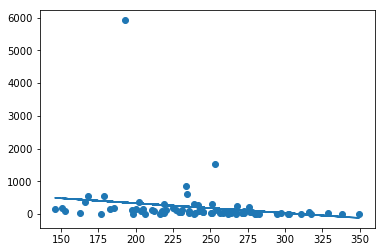

In [74]:
# testing visualization before exporting to Javascript
plt.figure(1)
plt.scatter(total_death, negSentiment)
m, b = np.polyfit(total_death,negSentiment,1)
plt.plot(total_death,m*total_death+b, '-')
plt.show()

In [80]:
df

,area_code,area_name,foodTweets,negSentiment,pmDiabete,pmHeart,posSentiment,totDeath
0,20110,Alpine (S),10,76,NaN,25.324568,89,217.737633
1,20260,Ararat (RC),0,12,7.156045,28.676790,10,310.710373
2,20570,Ballarat (C),5,93,6.570339,24.378532,74,272.713711
3,20660,Banyule (C),6,117,3.992572,16.499854,45,197.233979
4,20740,Bass Coast (S),5,45,5.357318,21.849796,32,228.854806
5,20830,Baw Baw (S),2,28,6.002301,21.535428,15,239.376485
6,20910,Bayside (C),9,534,3.291100,11.254516,200,168.155159
7,21010,Benalla (RC),2,13,NaN,25.606004,9,280.072124
8,21110,Boroondara (C),24,180,2.403751,13.286631,120,150.961177
9,21180,Brimbank (C),9,100,10.422516,25.620079,80,235.887106


In [ ]:
# The following is simply to extract data to be graphed on JavaScript on the Front end

In [96]:
deathvsNeg = []
for i in range(len(total_death)):
    deathvsNeg.append([list(negSentiment)[i],list(total_death)[i]])
# deathvsNeg # for export to JavaScript

In [98]:
deathvsPos = []
for i in range(len(total_death)):
    deathvsPos.append([list(posSentiment)[i],list(total_death)[i]])
# deathvsPos # for export to JavaScript

In [101]:
deathvsFood = []
for i in range(len(total_death)):
    deathvsFood.append([list(food)[i], list(total_death)[i]])
# deathvsFood
sp.stats.pearsonr(food,total_death)

(-0.18992492490762916, 0.091526346216779922)

In [110]:
pmHeartvsNeg = []
for i in range(len(total_death)):
    pmHeartvsNeg.append([list(negSentiment)[i],list(pmHeart)[i]])
# pmHeartvsNeg # for export to JavaScript

In [113]:
pmHeartvsPos = []
for i in range(len(total_death)):
    pmHeartvsPos.append([list(posSentiment)[i],list(pmHeart)[i]])
# pmHeartvsPos

In [ ]:
pmHeartvsFood = []
for i in range(len(total_death)):
    pmHeartvsFood.append([list(food)[i],list(pmHeart)[i]])
pmHeartvsFood